# Solve and simulate the bistable toggle switch

In this notebook, we study the deterministic and stochastic bistable toggle switch following the analysis presented in Figure 4 of Bocci and collaborators. The toggle switch is formed by two species that mutually repress each other, and can be described by the coupled ordinary differential equations:
$\frac{dx}{dt}=k\ \frac{1}{1 + \left( \frac{y}{t_0} \right)^n} - \gamma\ x$

$\frac{dy}{dt}=k\ \frac{1}{1 + \left( \frac{x}{t_0} \right)^n} - \gamma\ y$

where $x$ and $y$ are the concentrations of the chemical species, $k$ and $\gamma$ are basal production and degradation rates, $t_0$ is a threshold concentration when the repressive effect becomes important and $n$ is a parameter that modulates how sensitive the regulation is with respect to changes in molecule concentration. For simplicity, we have assumes symmetric parameters for the two species.

In this notebook, we will explore the following topics:

1) Solve the deterministic toggle switch and conduct a parameter sensitivity analysis;

2) Simulate the stochastic toggle switch and construct the pseudopotential landscape .

First, we import the necessary libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Studying the deterministic toggle switch

First, we define the **Hill function** used to model the repression between species, and introduce the model parameters that we will use throughout the notebook.

In [2]:
def Hill(x,x0,n):
    return 1/( 1 + (x/x0)**n )

In [3]:
k = 10 
g = 0.1
n = 4 
I0 = 80.

The fixed points accessible to this system can be visualized by plotting the **nullclines**. Nullclines are the curves obtained when setting each of the toggle switch equations to zero (independently from the other one). This gives:

$x=\frac{k}{\gamma} \frac{1}{1 + \left( \frac{y}{t_0} \right)^n}$

$y=\frac{k}{\gamma} \frac{1}{1 + \left( \frac{x}{t_0} \right)^n}$

These equations define curves in the $(x, y)$ phase space. We first define a function to compute the nullclines:

In [1]:
def nullcline(z, k, z0, n, g):
    return k*Hill(z,z0,n)/g

Using this function. we can plot the two nullclines and discover three intersection points corresponding to fixed points of the tioggle switch (i.e., points where both $\frac{dx}{dt}=0$ and $\frac{dy}{dt}=0$).

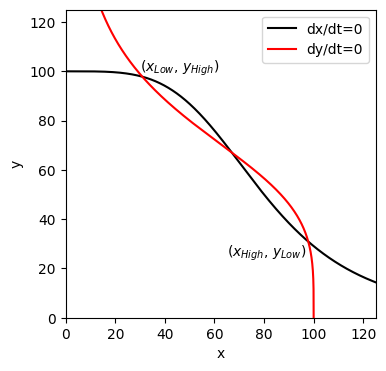

In [5]:
plt.figure(figsize=(4,4))

ax1 = plt.subplot(111)
x = np.arange(0., 125.1, 0.1)
y = np.arange(0., 125.1, 0.1)
null_y = nullcline(x, k, I0, n, g)
null_x = nullcline(y, k, I0, n, g)
plt.plot(x, null_y, 'k-', label='dx/dt=0');
plt.plot(null_x, y, 'r-', label='dy/dt=0');

# some further commands to make the plot nicer
plt.text(30, 100, '($x_{Low}$, $y_{High}$)');
plt.text(65, 25, '($x_{High}$, $y_{Low}$)');
plt.xlim([0,125])
plt.ylim([0,125])
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper right');

The two symmetric fixed points corresponding to (high x, low y) and (low x, high y) are stable and can be interpreted as "cell states", whereas the intermediate (medium x, medium y) state is unstable. The stability of the fixed points can be probed, for instance, by staring from different initial conditions and following the equilibration of the deterministic model. 

First, we define a function to integrate the toggle switch equations with a forward integration scheme. This function takes the following arguments:

1) The intial conditions ($xic$, $yic$);

2) Integration parameters including the timestep ($dt$) and length of integration ($npoints$);

3) The model parameters ($k$, $t_0$,  $n$, $\gamma$). While we assume same values for x and y parameters, they are defined separately to make the function more general.

In [2]:
def integrate( xic, yic, npoints, dt, kx, I0x, nx, gx, ky, I0y, ny, gy):
    # vectors to be filled with trajectory points
    x = np.zeros(npoints+1)
    y = np.zeros(npoints+1)
    # set the initial conditions
    x[0]=xic
    y[0]=yic

    # time integration
    for i in range(npoints):
        x[i+1] = x[i] + dt*( kx*Hill(y[i],I0x,nx) - gx*x[i] )
        y[i+1] = y[i] + dt * (ky * Hill(x[i], I0y, ny) - gy * y[i])
    return x, y

We set up 4 initial conditions in the vicinity of the 3 fixed points and plot their relaxation. The two initial conditions nearby the (high X, low Y) and (low X, high Y) fixed points quickly converge to their respective attractors, whereas the two conditions that start nearby the intermediate fixed point slowly separate and relax to the stable fixed points.

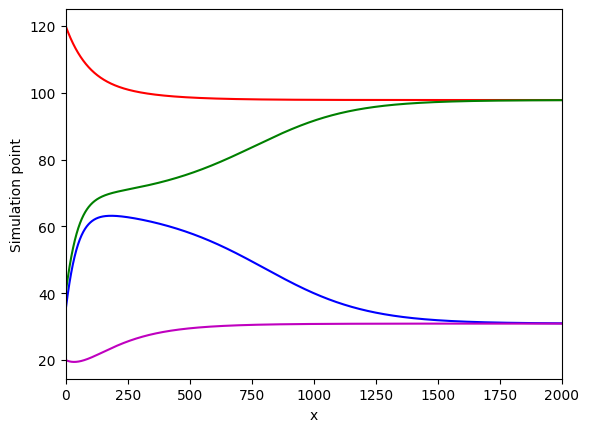

In [35]:
dt = 0.1
npoints = 2000

IC = [ [120,20], [35,40], [40,35], [20, 120] ]
color = ['r', 'b', 'g', 'm']

for ic,c in zip(IC, color):
    x, y = integrate(ic[0], ic[1], npoints, dt, k, I0, n, g, k, I0, n, g)
    plt.plot(x, color=c)
plt.xlabel('x');
plt.ylabel('Simulation point');
plt.xlim([0, 2000]);

Having established that the circuit gives rise to two stable states, we can further explore the sensitivity of the model with respect to local perturbations (i.e., when the model parameter are changed by a small amount).

To study the local sensitivity, we will focus on one fixed point (the high x, low y) and modify the value of each parameter by +5% or -5%, one at a time, and track the corresponding change in the equilibration value of x.

In [36]:
# define a vector with value of all parameters
p = np.array([k, I0, n, g, k, I0, n, g])

# use an ad hoc initial condition to obtain the values of (x,y) in the (high x, low y stable state)
ic = [100, 30]
x, y = integrate(ic[0], ic[1], npoints, dt, p[0], p[1], p[2], p[3], p[4], p[5], p[6], p[7])
x0, y0 = x[-1], y[-1]

# define vectors to save equilibrium levels of x and y upon parameter change
x_plus = np.zeros(p.size)
x_minus = np.zeros(p.size)

# loop over all parameters, modifying the value by +5% or -5%
for i in range(p.size):
    p_old = p[i]
    p[i] = 0.95*p_old
    x1, y1 = integrate(ic[0], ic[1], npoints, dt, p[0], p[1], p[2], p[3], p[4], p[5], p[6], p[7])
    x_minus[i] = x1[-1]
    p[i] = 1.05*p_old
    x2, y2 = integrate(ic[0], ic[1], npoints, dt, p[0], p[1], p[2], p[3], p[4], p[5], p[6], p[7])
    x_plus[i] = x2[-1]
    p[i] = p_old

x_minus = 100*(x0-x_minus)/x0
x_plus = 100*(x0-x_plus)/x0

We can visualize the result of this analysis as a bar plot:

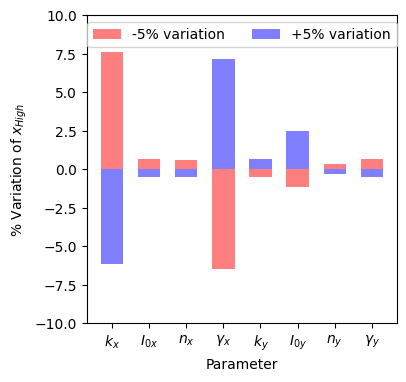

In [37]:
fig = plt.figure(figsize=(4,4))
ax = plt.subplot(111)

x = np.arange(0, x_minus.size, 1)

plt.bar( x, x_minus, width=0.6, color='r', align='center', alpha=0.5, label='-5% variation' )
plt.bar( x, x_plus, width=0.6, color='b', align='center', alpha=0.5, label='+5% variation' )
par_names = [ '$k_{x}$', '$I_{0x}$', '$n_{x}$', '$\gamma_{x}$', '$k_{y}$', '$I_{0y}$', '$n_{y}$', '$\gamma_{y}$' ]
plt.xticks(x, labels=par_names)
plt.legend(loc='upper center', ncol=2)
plt.ylim([-10, 10])
plt.xlabel('Parameter');
plt.ylabel('% Variation of $x_{High}$');

These results show that the percentage variation of x is of same order of magniture as the percentage variation of the parameters, roughly between 1% and 10%. This is a typical response to parameter perturbation in a stable fixed point.

## Simulating the stochastic toggle switch

We now introduce stochastic fluctuations in the toggle switch. Differently from the protein synthesis tutorial, we introduce noise in the deterministic toggle switch model by including a white noise term: 

In [38]:
def integrate_noise( sigma, xic, yic, npoints, dt, kx, I0x, nx, gx, ky, I0y, ny, gy):
    x = np.zeros(npoints+1)
    y = np.zeros(npoints+1)
    x[0]=xic
    y[0]=yic

    for i in range(npoints):
        x[i+1] = x[i] + dt*( k*Hill(y[i],I0,n) - g*x[i] ) \
                 + sigma*np.random.normal(loc=0., scale=np.sqrt(dt))
        y[i+1] = y[i] + dt * (k * Hill(x[i], I0, n) - g * y[i]) \
                 + sigma*np.random.normal(loc=0., scale=np.sqrt(dt))
    return x, y

In the new terms on the RHS, the parameter $\sigma$ represents the amplitude of the stochastic fluctuations. At each integration time point, this amplitude is multiplied by a Gaussian random number from a distribution with mean=0 and variance=1. 

Simulating when starting from one of the stable fixed points of the deterministic shows fluctuations arount the fixed points:

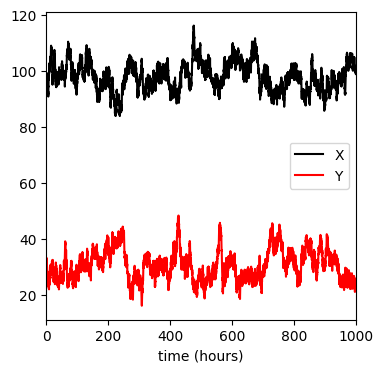

In [40]:
fig = plt.figure(figsize=(4,4))
ax = plt.subplot(111)

sigma = 2 #10
npoints = 10000

x, y = integrate(100, 70, npoints, dt, k, I0, n, g, k, I0, n, g)
xc1, yc1 = x[-1], y[-1]

np.random.seed(100)
x, y = integrate_noise( sigma, xc1, yc1, npoints, dt, k, I0, n, g, k, I0, n, g)
plt.plot( np.linspace(0., npoints*dt, npoints+1), x, 'k-', label='X')
plt.plot( np.linspace(0., npoints*dt, npoints+1), y, 'r-', label='Y')
plt.xlim([0, npoints/10])
plt.xlabel('time (hours)');
plt.legend(loc='center right');

Now we use data from the stochastic simulations to construct the pseudopotential landscape of the toggle switch. Given the small size and simplicity of this circuit, we simply simulate the circuit multiple times, taking care of starting some of the simulations from either of the two stable fixed points, to thoroughly sample the entire phase space. The data from independent simulations is then merged and used to construct a two-dimensional probability density. 

The pseudopotential is obtained by taking the negative, base-10 log of the probability density. Please refer to Bocci and collaborators for a more detailed explanation of the pseudopotentiual landscape and its connection with the potentiual energy of more traditional physical systems.

In [46]:
nsim = 10
sigma = 2
npoints = 2000
x_data, y_data = np.array([]), np.array([])

for i in range(nsim):
    x1, y1 = integrate_noise(sigma, xc1, yc1, npoints, dt, k, I0, n, g, k, I0, n, g)
    x2, y2 = integrate_noise(sigma, xc2, yc2, npoints, dt, k, I0, n, g, k, I0, n, g)
    x_data, y_data = np.concatenate( (x_data, x1, x2) ), np.concatenate( (y_data, y1, y2) )

xbins = np.linspace(0, 1.2*np.amax(x_data), 50)
ybins = np.linspace(0, 1.2*np.amax(y_data), 50)
dx, dy = xbins[1]-xbins[0], ybins[1]-ybins[0]
dist, xbin, ybin = np.histogram2d( x_data, y_data, bins=(xbins, ybins) )
dist[dist==0] += 1

dist = dist/( np.sum(dist)*dx*dy )
dist = -np.log10(dist)

(1.415776644587019, 137.33033452494084)

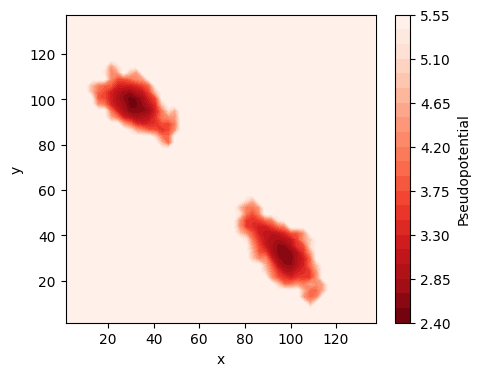

In [47]:
fig = plt.figure(figsize=(5,4))
ax = plt.subplot(111)

x, y = xbins[0:-1]+dx/2, ybins[0:-1]+dy/2;
pt = plt.contourf(x, y, dist, 21, cmap='Reds_r');
cbar = plt.colorbar(pt, label='Pseudopotential');
plt.xlabel('x');
plt.ylabel('y');
plt.xlim([x[0], x[-1]])
plt.xlim([y[0], y[-1]])

The pseudopotential highlights two areas of high probability (and thus low potential) roughly corresponding to the positions where the stable fixed points were found in the deterministic case. Therefore, this landscape suggests that the system spends the majority of its time fluctuating around either of the two attractors, and only very rarely large deviations can induce a switch from one attractor to the other. 